In [1]:
!ls

Model Build.ipynb connection.py     players_list.json
__init__.py       data.py           squad.py
__pycache__       game.py           utils.py


In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

import json
import random
import matplotlib as pyplot
from tqdm import tqdm

from fpl21.utils import pp

### Generate base data set
<hr>

In [5]:
with open("players_list.json", "r") as f:
    players_list = json.load(f)

loading players list from file


In [6]:
# Players list file contains player attributes, fixtures list, historical fixtures and previous season performance
players_list[0].keys()

dict_keys(['chance_of_playing_next_round', 'chance_of_playing_this_round', 'code', 'cost_change_event', 'cost_change_event_fall', 'cost_change_start', 'cost_change_start_fall', 'dreamteam_count', 'element_type', 'ep_next', 'ep_this', 'event_points', 'first_name', 'form', 'id', 'in_dreamteam', 'news', 'news_added', 'now_cost', 'photo', 'points_per_game', 'second_name', 'selected_by_percent', 'special', 'squad_number', 'status', 'team', 'team_code', 'total_points', 'transfers_in', 'transfers_in_event', 'transfers_out', 'transfers_out_event', 'value_form', 'value_season', 'web_name', 'minutes', 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded', 'own_goals', 'penalties_saved', 'penalties_missed', 'yellow_cards', 'red_cards', 'saves', 'bonus', 'bps', 'influence', 'creativity', 'threat', 'ict_index', 'influence_rank', 'influence_rank_type', 'creativity_rank', 'creativity_rank_type', 'threat_rank', 'threat_rank_type', 'ict_index_rank', 'ict_index_rank_type', 'corners_and_indirect_fr

In [7]:
#history is previous fictures with stats. fixtures is forward looking
len(players_list[0]['history']), len(players_list[0]['fixtures'])

(4, 34)

#### Static player attributes

In [8]:
# Create a player attrs dataframe
keys = ['id', 'web_name', 'element_type', 'team', 'ep_this', 'ep_next']

player_attrs = pd.DataFrame(
    [[p[key] for key in keys] for p in players_list],
    columns=keys)

player_attrs.rename(columns={'id': 'element'}, inplace=True)
#player_attrs

#### Historical match data

In [9]:
hist = [p['history'] for p in players_list]
df = pd.DataFrame([x for sublist in hist for x in sublist])
df.rename(columns={'was_home': 'is_home'}, inplace=True)
df = df.merge(player_attrs, on='element')

#### Fixture data

In [10]:
players_list[100]['fixtures'][0]

{'id': 42,
 'code': 2210312,
 'team_h': 4,
 'team_h_score': None,
 'team_a': 9,
 'team_a_score': None,
 'event': 5,
 'finished': False,
 'minutes': 0,
 'provisional_start_time': False,
 'kickoff_time': '2021-09-19T13:00:00Z',
 'event_name': 'Gameweek 5',
 'is_home': True,
 'difficulty': 4}

In [11]:
# naive version of team diffculty
# average points per game
team_difficulty = df.groupby('team').total_points.sum() / df.groupby('team').fixture.nunique()
team_difficulty.name = 'team_difficulty'

In [12]:
#team_difficulty

In [13]:
df = df.merge(team_difficulty, left_on='opponent_team', right_index=True) \
       .rename(columns={'team_difficulty': 'opponent_difficulty'}) \
       .merge(team_difficulty, left_on='team', right_index=True)

In [14]:
df.head()

,element,fixture,opponent_team,total_points,is_home,kickoff_time,team_h_score,team_a_score,round,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,value,transfers_balance,selected,transfers_in,transfers_out,web_name,element_type,team,ep_this,ep_next,opponent_difficulty,team_difficulty
0,1,1,3,1,False,2021-08-13T19:00:00Z,2.0,0.0,1,90,0,0,0,2,0,0,0,0,0,1,0,11,11.8,0.0,0.0,1.2,50,0,153122,0,0,Leno,1,1,2.0,2.0,45.0,26.0
4,2,1,3,0,False,2021-08-13T19:00:00Z,2.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,40,0,91500,0,0,Rúnarsson,1,1,0.0,0.0,45.0,26.0
8,3,1,3,0,False,2021-08-13T19:00:00Z,2.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,65,0,22000,0,0,Willian,3,1,0.0,0.0,45.0,26.0
12,4,1,3,0,False,2021-08-13T19:00:00Z,2.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,100,0,200068,0,0,Aubameyang,4,1,4.7,4.7,45.0,26.0
16,5,1,3,0,False,2021-08-13T19:00:00Z,2.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,45,0,17385,0,0,Cédric,2,1,1.3,1.3,45.0,26.0


In [15]:
labels = ['element', 'web_name', 'fixture', 'round',]

# Static player attributes
player_cols = ['element_type']#, 'ep_this', 'ep_next']

# Attributes from fixture data
fixtures_cols = ['is_home', 'team', 'team_difficulty', 'opponent_team', 'opponent_difficulty']

# Historical match data - contains outcomes and things that are correlated, e.g. number of minutes played
# Need to be lagged to use as predictors
history_cols = ['total_points', 'bonus', 'bps', 'minutes', 'selected', 'transfers_in', 'transfers_out'] 

df = df[labels + player_cols + fixtures_cols + history_cols]

# Others

# 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded',
# 'own_goals', 'penalties_saved', 'penalties_missed', 'yellow_cards',
# 'red_cards', 'saves', 'influence', 'creativity',
# 'threat', 'ict_index', 'value', 'transfers_balance',


In [16]:
df

,element,web_name,fixture,round,element_type,is_home,team,team_difficulty,opponent_team,opponent_difficulty,total_points,bonus,bps,minutes,selected,transfers_in,transfers_out
0,1,Leno,1,1,1,False,1,26.000000,3,45.0,1,0,11,90,153122,0,0
4,2,Rúnarsson,1,1,1,False,1,26.000000,3,45.0,0,0,0,0,91500,0,0
8,3,Willian,1,1,3,False,1,26.000000,3,45.0,0,0,0,0,22000,0,0
12,4,Aubameyang,1,1,4,False,1,26.000000,3,45.0,0,0,0,0,200068,0,0
16,5,Cédric,1,1,2,False,1,26.000000,3,45.0,0,0,0,0,17385,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,463,Firpo,6,1,2,False,10,17.166667,13,55.0,-1,0,4,45,61450,0,0
1142,490,Klaesson,6,1,1,False,10,17.166667,13,55.0,0,0,0,0,9800,0,0
1146,550,Greenwood,6,1,4,False,10,17.166667,13,55.0,0,0,0,0,0,0,0
1150,551,Summerville,6,1,3,False,10,17.166667,13,55.0,0,0,0,0,0,0,0


<AxesSubplot:>

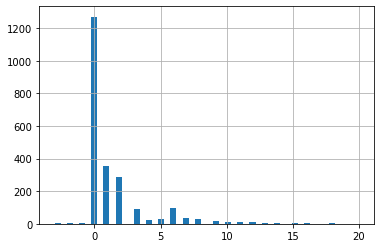

In [17]:
df.total_points.hist(bins=50)

### Feature generation
<hr>

In [18]:
def rolling_avg(df, window, col, default):
    rolling = pd.Series(dtype='float64')
    for x in df.element.unique():
        rolling = rolling.append(df[df.element==x].sort_values('fixture').rolling(window)[col].mean().shift(1))
    
    # Fill nas with default val
    rolling = rolling.fillna(default)
    
    rolling.name = f"avg_{col}_L{window}"
    return df.merge(rolling, left_index=True, right_index=True)

In [19]:
for var in tqdm(history_cols): # we can use previous outcomes to predict next values
    df = rolling_avg(df, 1, var, 0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:06<00:00,  1.08it/s]


In [20]:
df.sort_index().head(10)

,element,web_name,fixture,round,element_type,is_home,team,team_difficulty,opponent_team,opponent_difficulty,total_points,bonus,bps,minutes,selected,transfers_in,transfers_out,avg_total_points_L1,avg_bonus_L1,avg_bps_L1,avg_minutes_L1,avg_selected_L1,avg_transfers_in_L1,avg_transfers_out_L1
0,1,Leno,1,1,1,False,1,26.0,3,45.00,1,0,11,90,153122,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,Leno,18,2,1,True,1,26.0,6,65.00,2,0,17,90,144885,2627,28443,1.0,0.0,11.0,90.0,153122.0,0.0,0.0
2,1,Leno,24,3,1,False,1,26.0,12,64.75,1,0,20,90,136757,5164,19723,2.0,0.0,17.0,90.0,144885.0,2627.0,28443.0
3,1,Leno,31,4,1,True,1,26.0,15,16.80,0,0,0,0,153130,35360,28796,1.0,0.0,20.0,90.0,136757.0,5164.0,19723.0
4,2,Rúnarsson,1,1,1,False,1,26.0,3,45.00,0,0,0,0,91500,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2,Rúnarsson,18,2,1,True,1,26.0,6,65.00,0,0,0,0,105244,5814,5249,0.0,0.0,0.0,0.0,91500.0,0.0,0.0
6,2,Rúnarsson,24,3,1,False,1,26.0,12,64.75,0,0,0,0,104983,4471,6925,0.0,0.0,0.0,0.0,105244.0,5814.0,5249.0
7,2,Rúnarsson,31,4,1,True,1,26.0,15,16.80,0,0,0,0,95398,8732,20189,0.0,0.0,0.0,0.0,104983.0,4471.0,6925.0
8,3,Willian,1,1,3,False,1,26.0,3,45.00,0,0,0,0,22000,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,3,Willian,18,2,3,True,1,26.0,6,65.00,0,0,0,0,18418,710,7955,0.0,0.0,0.0,0.0,22000.0,0.0,0.0


### Build model
<hr>

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [22]:
# only use data where rolling metrics are populated
df = df[df['round'] > 1]

In [23]:
df.element_type = df.element_type.astype(str)
df.team = df.team.astype(str)
df.opponent_team = df.opponent_team.astype(str)

In [24]:
covars = [name for name in df.columns if name not in labels + history_cols]

X = df[covars]
y = df.total_points

In [25]:
X.dtypes

element_type             object
is_home                    bool
team                     object
team_difficulty         float64
opponent_team            object
opponent_difficulty     float64
avg_total_points_L1     float64
avg_bonus_L1            float64
avg_bps_L1              float64
avg_minutes_L1          float64
avg_selected_L1         float64
avg_transfers_in_L1     float64
avg_transfers_out_L1    float64
dtype: object

In [26]:
# Custom train/test split to ensure all player observations in same set
# To prevent overstating test performance
elements = list(df.element.unique())
test_elements = random.sample(elements, len(elements) // 4)
mask = np.array([(x in test_elements) for x in df.element])


In [27]:
X_train = X[~mask]
y_train = y[~mask]
X_test = X[mask]
y_test = y[mask]

In [28]:
train = (X_train, y_train)
test = (X_test, y_test)

In [29]:
X_train.shape, X_test.shape

((1307, 13), (435, 13))

In [30]:
reg = RandomForestRegressor(min_samples_split=100)

In [31]:
reg.fit(*train)

RandomForestRegressor(min_samples_split=100)

<AxesSubplot:>

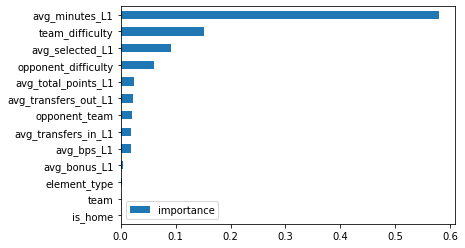

In [32]:
pd.DataFrame(reg.feature_importances_, index=covars, columns=['importance']) \
    .sort_values('importance').plot(kind='barh')

In [33]:
print(f"Train {reg.score(*train)}")
print(f" Test {reg.score(*test)}")

Train 0.43410769466394605
 Test 0.29580342815630445


In [34]:
# Change Log (Test performance)

# 0.4000 - using ep_this, ep_next
# 0.1528 - baseline
# 0.1693 - more vars
# 0.1654 - new train test split to keep all player observations in one set and avoid overstating test performance
# 0.2757 - training/evaluation done on rows where rolling metrics are populated
# 0.2920 - teams labels and my team difficulty

In [35]:
def scatter(df, x, y, noise=False):
    """Scatter plot with random noise to facilitate comparing continuous predictions with integer scores"""
    jitter = df[[x, y]]
    
    if noise:
        nx = np.random.normal(0, 0.2, len(df)) 
        ny = np.random.normal(0, 0.2, len(df)) 
        jitter[x] += nx
        jitter[y] += ny

    jitter.plot.scatter(x, y)

In [36]:
# Parameter tuning
# results = []
# for n in tqdm([2, 5, 10, 20, 50, 100, 200, 500, 1000]):
#     reg = RandomForestRegressor(n_estimators=n, min_samples_split=100)
#     reg.fit(X_train, y_train)
#     results.append((n, reg.score(*train), reg.score(*test)))

# pd.DataFrame(results, columns=['ntrees', 'train', 'test']).set_index('ntrees').plot()

<AxesSubplot:>

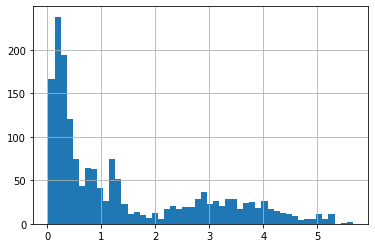

In [37]:
df['predicted_points'] = reg.predict(df[covars])
df['predicted_points'].hist(bins=50)

/var/folders/l7/z2rc83xj63j94dmctwtwhw5c0000gn/T/ipykernel_1130/2415938938.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jitter[x] += nx
/var/folders/l7/z2rc83xj63j94dmctwtwhw5c0000gn/T/ipykernel_1130/2415938938.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jitter[y] += ny


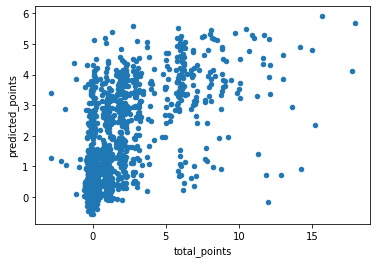

In [38]:
scatter(df, 'total_points', 'predicted_points', noise=True)

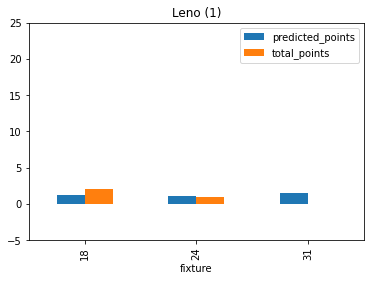

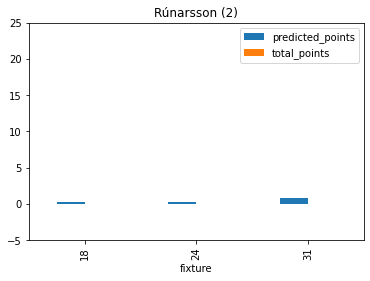

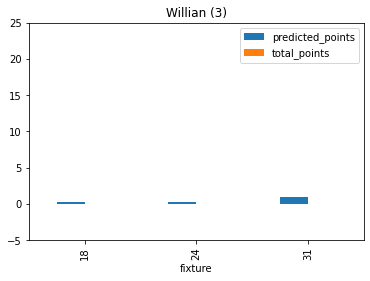

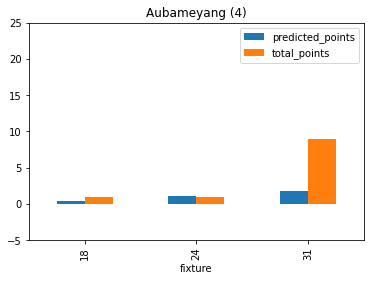

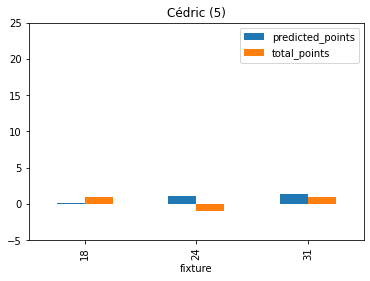

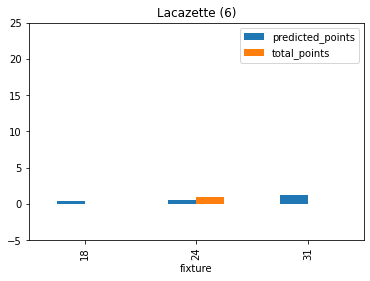

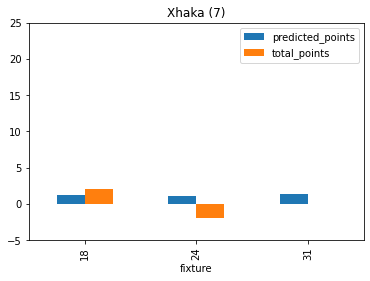

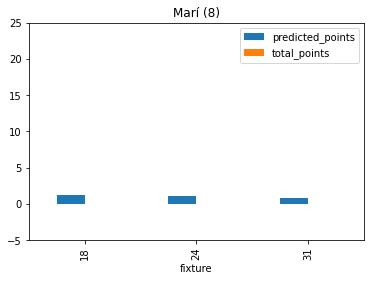

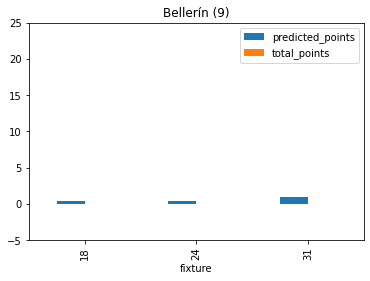

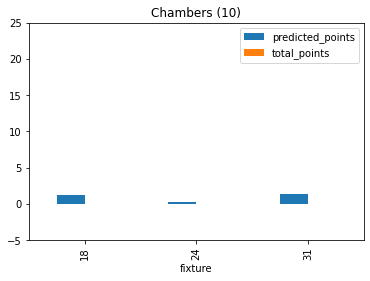

In [39]:
def plot_predicted_points(df, pid):
    player = df[df.element==pid]
    player.set_index('fixture').sort_index()[['predicted_points', 'total_points']].plot(
        kind='bar', ylim=(-5, 25), title=f"{player.web_name.iloc[0]} ({pid})"
    )

for pid in df.element.unique()[:10]:
    plot_predicted_points(df, pid)

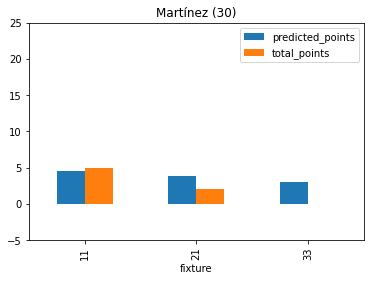

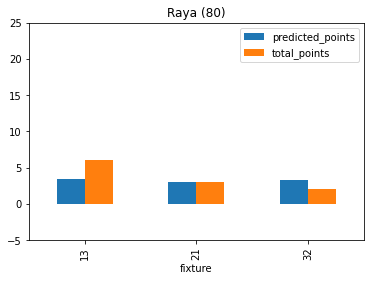

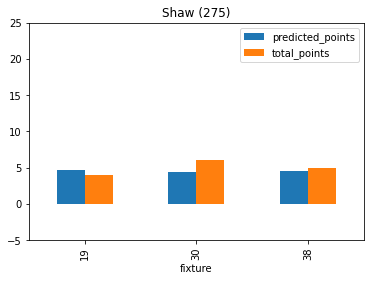

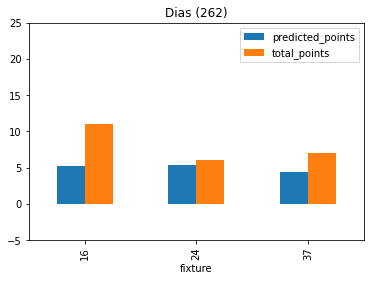

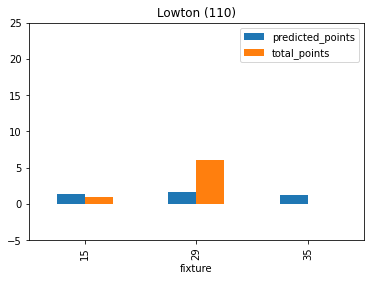

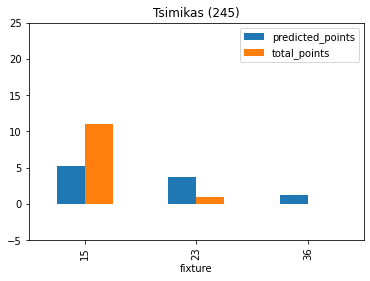

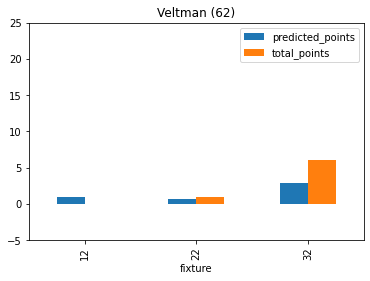

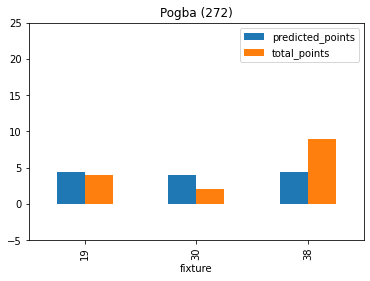

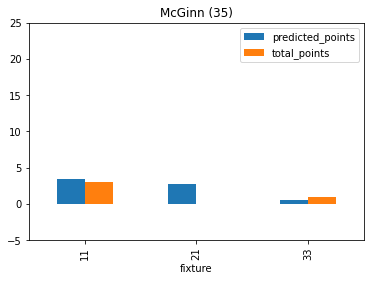

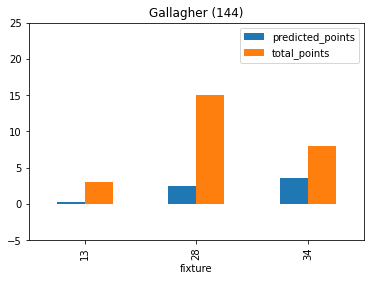

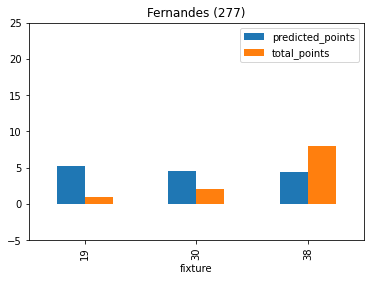

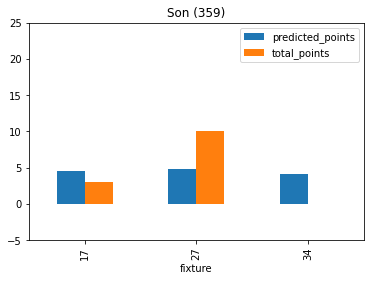

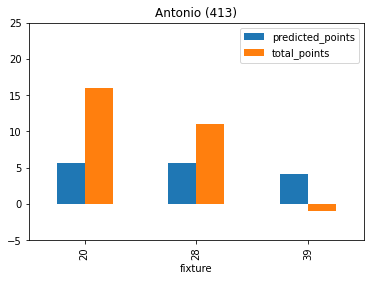

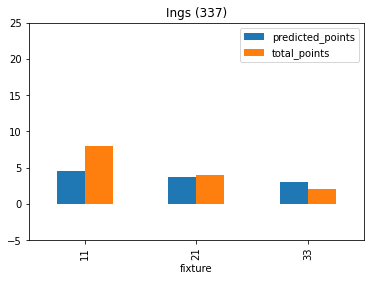

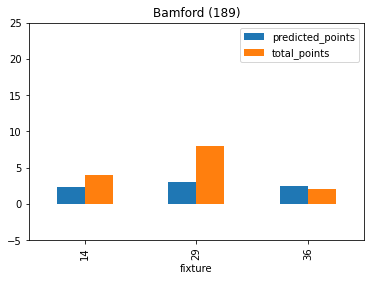

In [40]:
for pid in [30, 80, 275, 262, 110, 245, 62, 272, 35, 144, 277, 359, 413, 337, 189]:
    plot_predicted_points(df, pid)